In [1]:
from discopy import *

In [2]:
w, s, n = Ty('w'), Ty('s'), Ty('n')

Alice = Word('Alice', n, dom=w)
loves = Word('loves', n.r @ s @ n.l, dom=w)
Bob =  Word('Bob', n, dom=w)
who = Word('who', n.r @ n @ s.l @ n, dom=w)
is_rich = Word('is rich', n.r @ s, dom=w)

vocab = [Alice, loves, Bob, who, is_rich]

In [3]:
gen, n, sentences = grammar.brute_force(*vocab), 10, []
for _ in range(n): sentences.append(next(gen))

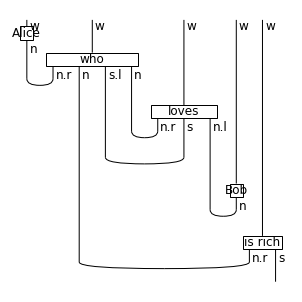

<AxesSubplot:>

In [4]:
sentences[-1].normal_form().draw()

In [5]:
def incremental(sentence):
    sentence = sentence.normal_form()
    words = [i for i, box in enumerate(sentence.boxes) if isinstance(box, Word)]
    for i, j in zip(words, words[1:] + [None]):
        step = sentence[i:j]
        length_previous_type, *_ = (i for i, x in enumerate(step.dom) if x.name == 'w')
        open_wires = step.dom[:length_previous_type]
        word = step.boxes[0]
        cups = Id(open_wires @ word.cod)
        for cup, offset in zip(step.boxes[1:], step.offsets[1:]):
            cups = cups >> Id(cups.cod[:offset]) @ cup @ Id(cups.cod[offset + 2:])
        yield open_wires, word, cups

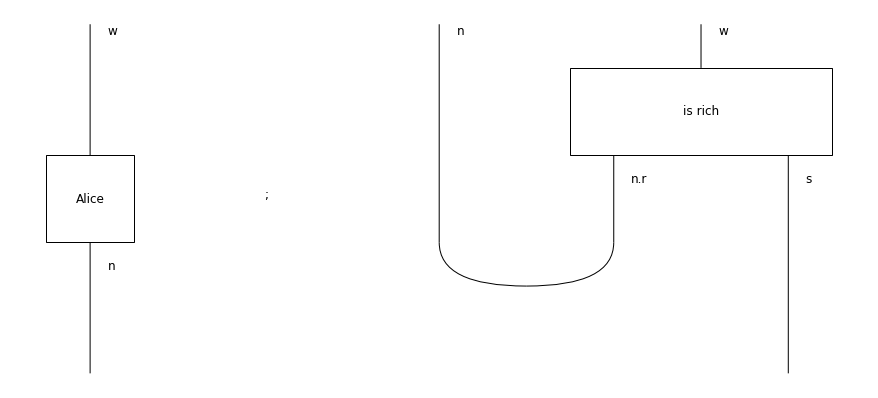

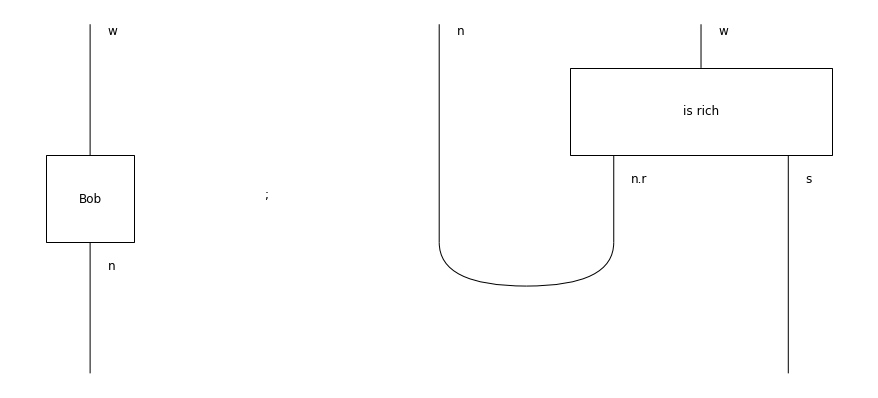

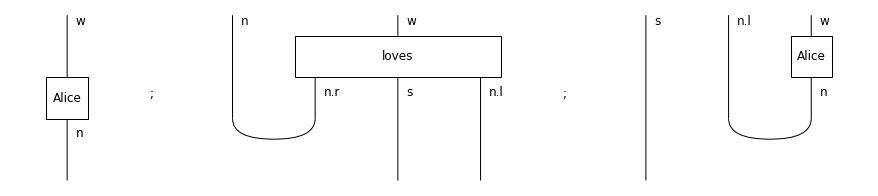

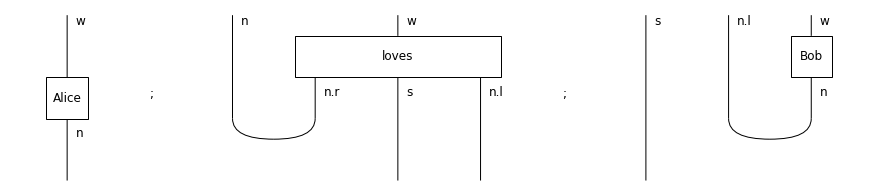

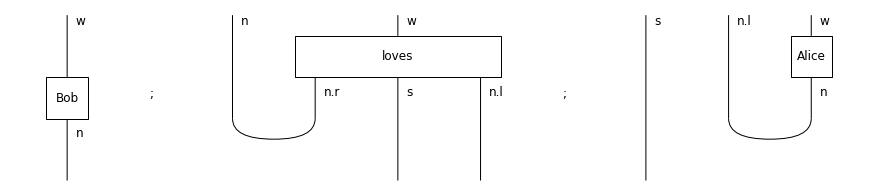

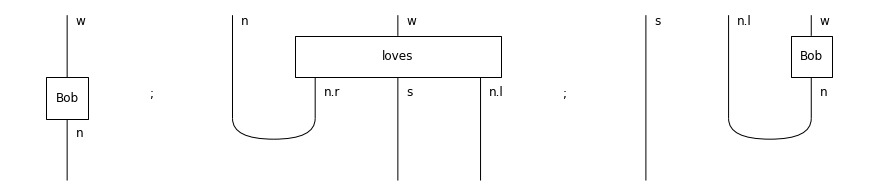

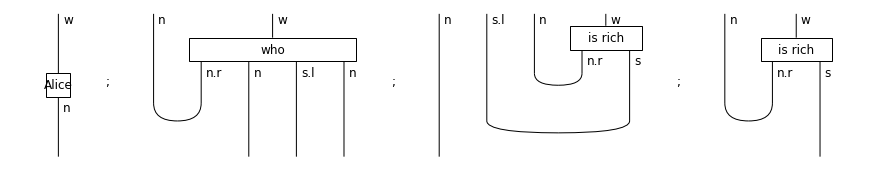

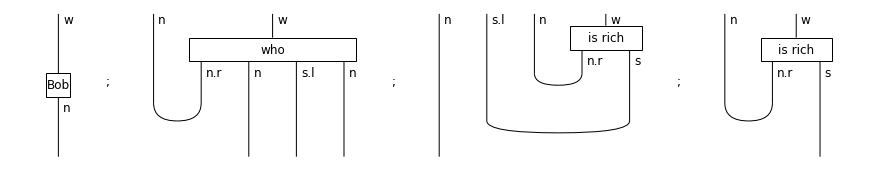

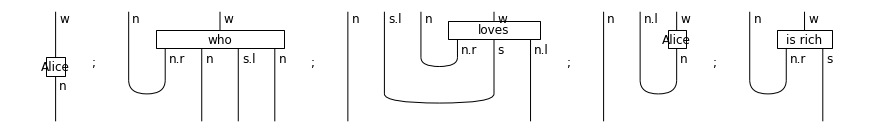

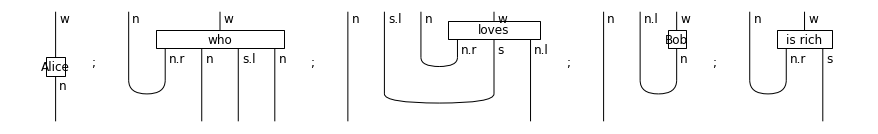

In [6]:
for sentence in sentences: drawing.equation(*(
    Id(open_wires) @ word >> cups for open_wires, word, cups in incremental(sentence)),
    symbol='; ', figsize=(12, 12))

In [7]:
transition = dict()
for sentence in sentences:
    for open_wires, word, cups in incremental(sentence):
        transition[open_wires] = transition.get(open_wires, dict())
        transition[open_wires][word.cod, cups] = transition[open_wires].get((word.cod, cups), 0) + 1

In [8]:
for open_wires, counts in transition.items():
    for (ty, cups), count in counts.items():
        print("Open wires {} get updated with a word of type {} and contractions {} ({} times)".format(open_wires, ty, cups, count))

Open wires Ty() get updated with a word of type n and contractions Id(n) (10 times)
Open wires n get updated with a word of type n.r @ s and contractions Cup(n, n.r) @ Id(s) (6 times)
Open wires n get updated with a word of type n.r @ s @ n.l and contractions Cup(n, n.r) @ Id(s @ n.l) (4 times)
Open wires n get updated with a word of type n.r @ n @ s.l @ n and contractions Cup(n, n.r) @ Id(n @ s.l @ n) (4 times)
Open wires s @ n.l get updated with a word of type n and contractions Id(s) @ Cup(n.l, n) (4 times)
Open wires n @ s.l @ n get updated with a word of type n.r @ s and contractions Id(n @ s.l) @ Cup(n, n.r) @ Id(s) >> Id(n) @ Cup(s.l, s) (2 times)
Open wires n @ s.l @ n get updated with a word of type n.r @ s @ n.l and contractions Id(n @ s.l) @ Cup(n, n.r) @ Id(s @ n.l) >> Id(n) @ Cup(s.l, s) @ Id(n.l) (2 times)
Open wires n @ n.l get updated with a word of type n and contractions Id(n) @ Cup(n.l, n) (2 times)


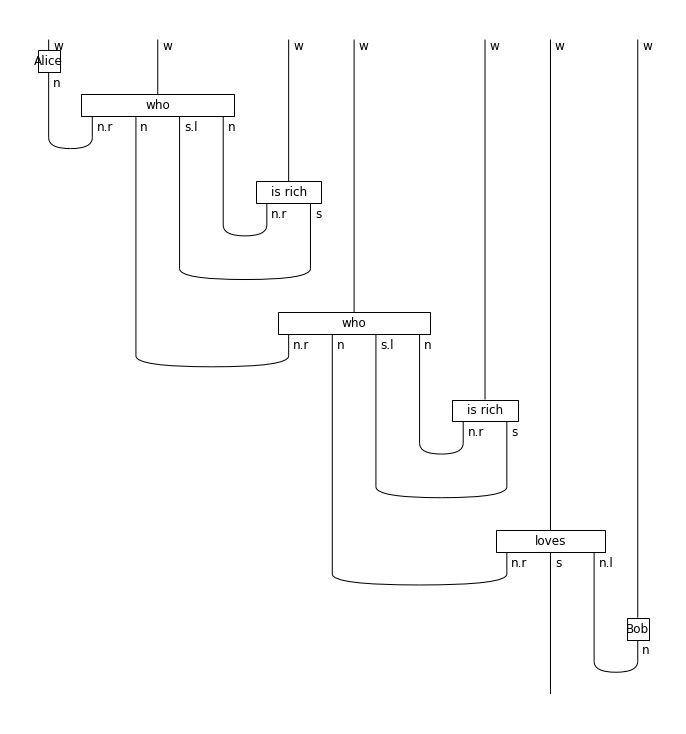

<AxesSubplot:>

In [32]:
import random; random.seed(1312)

state = Id(Ty())
while state.cod in transition:
    ty, cups = random.choice(sum([count * [option] for option in transition[state.cod]], []))
    word = random.choice([w for w in vocab if w.cod == ty])
    state = state @ word >> cups

state.draw(figsize=(10, 10))